# Info
This is a demo code for our recent work "Mental image reconstruction from human brain activity: Neural decoding of mental imagery via deep neural network-based Bayesian estimation".

<img src="https://drive.google.com/uc?id=1aXgnfMd3XH3ixNz3S44ii9MPqIQSVWvI" width="60%">

# Setup
* Clone our gitHub repository
* Download the visual and semantic features characterizing imagined images decoded (estimated) from brain activity

In [ ]:
# Clone the repository
!git clone https://github.com/pina-lab/mental_img_recon.git
#!git clone https://github.com/nkmjm/mental_img_recon.git
%cd mental_img_recon

from PIL import Image

Cloning into 'mental_img_recon'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 2.20 MiB | 8.35 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/mental_img_recon


In [ ]:
# Download the brain-decoded feature data from Google Drive
import gdown
import tarfile

# Set the public file ID
file_id = '1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq'
download_url = f'https://drive.google.com/uc?id={file_id}'
download_path = '/content/mental_img_recon/downloaded_file.tar.gz'
# Download the tar.gz file
gdown.download(download_url, download_path, quiet=False)

# Extract the downloaded tar.gz file
with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall(path='/content/mental_img_recon')

Downloading...
From (original): https://drive.google.com/uc?id=1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq
From (redirected): https://drive.google.com/uc?id=1Q7TVsVbASMqnDYfFjFzo2SV6njExu8qq&confirm=t&uuid=3ea3b4d9-d33b-494f-b959-2052c3529318
To: /content/mental_img_recon/downloaded_file.tar.gz
100%|██████████| 1.78G/1.78G [00:24<00:00, 71.8MB/s]


# Neural network model loading
*   Load the required neural network models (VQGAN, VGG19 and CLIP)





In [ ]:
# Install VQGAN
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml'
# Modify part of the code to be compatible with PyTorch 2.x
!sed -i 's/from torch._six import string_classes/string_classes = str/' ./taming/data/utils.py
# Install required libraries for VQGAN
%pip install -e .
%cd ..

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 43.43 MiB/s, done.
Resolving deltas: 100% (282/282), done.
/content/mental_img_recon/taming-transformers
--2024-06-28 03:39:43--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/de65d2d5-c963-41a3-b63b-9b9e4e405aaf/last.ckpt [following]
--2024-06-28 03:39:44--  https://heibox.uni-heidelberg.de/seafhttp/files/de65d2d5-c963-41a3-b63b-9b9e4e405aaf/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:

In [ ]:
#Install minimal required dependencies.
import subprocess
import sys

# List of packages to be installed if not already present
packages = [
    "mat73",
    "omegaconf",
    "einops",
    "ftfy",
    "pytorch-lightning"
]

# Function to check if a package is already installed
def check_installed(package):
    try:
        __import__(package)
    except ImportError:
        return False
    return True

# Identify packages that need to be installed
to_install = [pkg for pkg in packages if not check_installed(pkg)]

if to_install:
    # Install packages that are not already installed
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + to_install)
else:
    print("All packages are already installed.")


In [ ]:
# Install CLIP
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eyp9qnjv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eyp9qnjv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=f4af68b2d1f717b2410fb5ebb78b69c77124479db453d2e1e7f2951e19c9c322
  Stored in directory: /tmp/pip-ephem-wheel-cache-pajcq6h4/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import torch
import sys
import yaml

# Load demo params
with open('demo_params.yaml', 'rb') as f:  # config
    prm_demo = yaml.safe_load(f)
# Load config for imrecon
with open('config.yaml', 'rb') as f:  # config
    dt_cfg = yaml.safe_load(f)

# Set directory of taming_transformer
dir_taming_transformer = dt_cfg['file_path']['taming_transformer_dir']
sys.path.insert(0, dir_taming_transformer)

# Set GPU if it's available
cudaID = "cuda:0"
DEVICE = torch.device(cudaID if torch.cuda.is_available() else "cpu")

In [ ]:
import model_loading

# load VQGAN model
config1024 = model_loading.load_config(
    dir_taming_transformer+"/logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
VQGANmodel1024 = model_loading.load_vqgan(
    config1024, ckpt_path=dir_taming_transformer+"/logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
VQGANmodel1024.eval()

# Load VGG19 model
VGGmodel_, _ = model_loading.load_VGG_model(DEVICE)

# Load CLIP models to be used.
# set CLIPmodelName_
CLIP_modelNames = dt_cfg["models"]["CLIP"]["modelnames"]
CLIP_modelTypes = dt_cfg["models"]["CLIP"]["modeltypes"]
CLIP_usedLayer = dt_cfg["models"]["CLIP"]["used_layer"]
CLIPmodelWeight_ = dt_cfg["models"]["CLIP"]["modelcoefs"]
CLIPmodel_, nameOfSubdirForCLIPfeature = model_loading.load_CLIP_model(
    CLIP_modelTypes, DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 55.8MB/s]


8.19kB [00:00, 445kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.8MB/s]


nameOfCLIPmodelInTorch:
['ViT-B/32']
nameOfSubdirForCLIPfeature:
['CLIP_ViT-B_32']


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 192MiB/s]


# Set parameters
*   Choose subject (S01, S02, S03)
*   Choose target images for reconstruction (IDs 0-24)
*   Set minor option of the gradient method (original: adopted in Koide-Majima et al. (2024), Langevin: full Langevin dynamics algorihm with random initial values (slow convergence), withoutLangevin: using Adam instead of Langevin dynamics algorithm).




In [ ]:
subject = 'S02'  # select from 'S01', 'S02', 'S03'

targetID_list = [21, 20, 18]
# select from 0 to 24
# Here are examples:
# ID 21: 'Bowling ball (artifact)'
# ID 20: 'Airplane (artifact)'
# ID 18: 'Leopard (animal)'
# ID 19: 'Goat (animal)'
# ID  7: 'Blue + (symbol)'
# ID 14: 'Black x (symbol)'

reconMethod = 'original' # select from 'original' (default), 'Langevin', 'withoutLangevin'

# Reconstruction

Reconstruction is completed.
Subject: S02, method: original


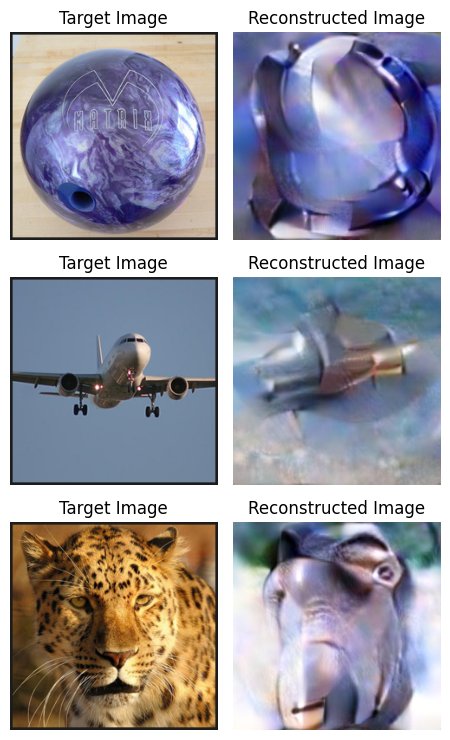

In [ ]:
# start reconstruction
import recon_utils as utils
utils.start_reconstruction(
    subject, targetID_list, reconMethod, dt_cfg, prm_demo,
    CLIPmodel_, VGGmodel_, CLIPmodelWeight_, VQGANmodel1024, DEVICE)